Notebook resources: 
- https://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/slides/lec06.pdf
- https://github.com/Avik-Jain/100-Days-Of-ML-Code/tree/master/Code
- http://scott.fortmann-roe.com/docs/BiasVariance.html

In [ ]:
# Motivation

# Motivation
- We want to reduce variance!
- The error due to variance is taken as the variability of a model prediction for a given data point. Again, imagine you can repeat the entire model building process multiple times. The variance is how much the predictions for a given point vary between different realizations of the model

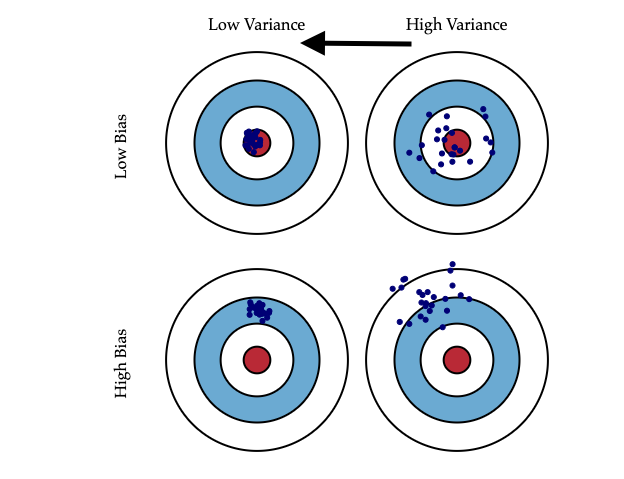

# Bagging

- Bagging, alson known as boostrap aggregation, is an ensemble learning method used to reduce variance. In bagging, a random subset sample of data is selected with replacement (individual points can be chosen more than once).

- Bagging consists of three steps:
  - Boostrapping: repeated resampling from training set
  - Sub-training: training a model (weak learner) on each bootstrapped sub-sample, separately
  - Combining the outputs of all models (mean for regression and voting for classification)

- Each model is trained on (approximately) 63% of data points, leaving 37% for validation (also called out-of-bag (OOB))
  

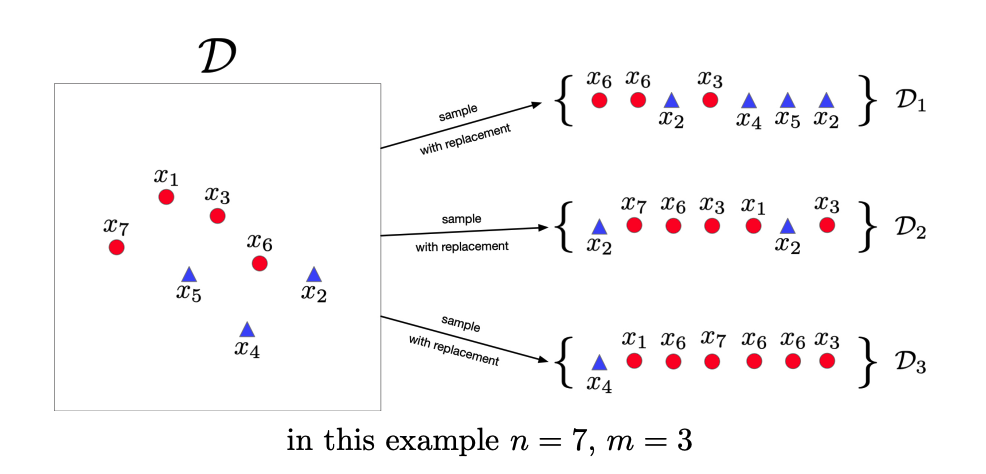

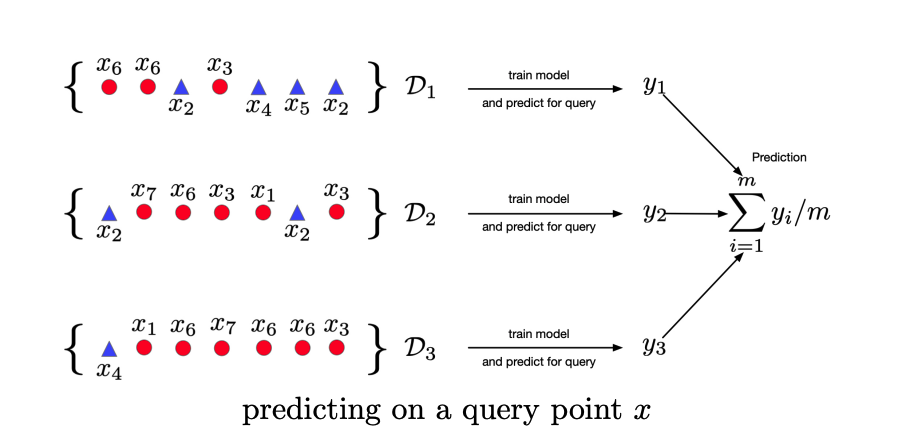

Lets create out synthetic example.

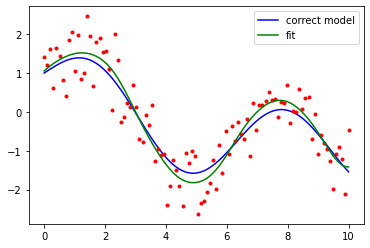

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)                        
y = yt + .5*np.random.randn(N) 
plt.plot(x, yt, 'b-', label='correct model')
# plt.legend()

plt.plot(x, y, 'r.')
phi = lambda x,mu: np.exp(-(x-mu)**2)
D = 10

mu = np.linspace(0,D,D) #10 Gaussians bases
Phi = phi(x[:,None], mu[None,:]) #N x 10
w = np.linalg.lstsq(Phi, y)[0]
yh = np.dot(Phi,w)

plt.plot(x, yh, 'g-', label='fit')
plt.legend()
plt.show()


Now we fit linear model to 500 bootstrap samples from this toy data, and plot the distribution of model weights obtained for all samples  


In [9]:
# random sampling with replacement
ids =np.random.randint(5, size=5)
print(ids)

[4 0 3 4 1]


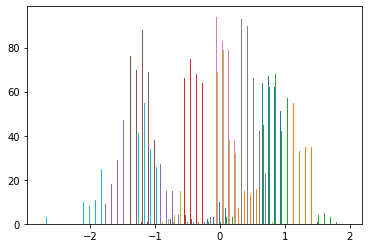

In [ ]:
#Phi: N x D
#y: N
B = 500 # number of models 

ws = np.zeros((B,D))
for b in range(B):
  inds = np.random.randint(N, size=(N)) # random sampling with replacement
  Phi_b = Phi[inds,:] #N x D

  y_b = y[inds] #N
  #fit the subsampled data
  ws[b,:] = np.linalg.lstsq(Phi_b, y_b)[0]
plt.hist(ws, bins=50)
plt.show()

lets plot the predictions from these 500 models on a test data, and compute their average predictions as the final prediction, plus plot the confidence intervals.

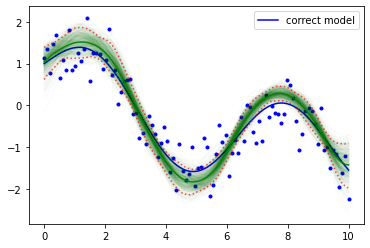

In [ ]:
#Phi: N x D
#Phi_test: Nt x D
#y: N

Nt = 100
xt = np.linspace(0,10, Nt)
yt = np.sin(xt) + np.cos(xt**.5)                
plt.plot(xt, yt, 'b-', label='correct model')
yt = yt  + .5*np.random.randn(Nt)
plt.plot(xt, yt, 'b.')
plt.legend()

Phi_test = phi(xt[:,None], mu[None,:]) #N x 10

#ws: B x D from previous code
y_hats = np.zeros((B, Nt))
for b in range(B):
  wb = ws[b,:]
  y_hats[b,:] = np.dot(Phi_test, wb)
  plt.plot(xt, y_hats[b,:], 'g-', alpha = 0.01)

# get 5%, 95% quantiles and mean
y_5 = np.quantile(y_hats, .05, axis=0)
y_mean = np.mean(y_hats, axis=0)
y_95 = np.quantile(y_hats, .95, axis=0)

plt.plot(xt, y_5, 'r:', alpha = 0.7)
plt.plot(xt, y_95, 'r:', alpha = 0.7)
plt.plot(xt, y_mean, 'g-', alpha = 0.9)
plt.show()

# Random Forrests
- Random Forrests is an extension of bagging and feature randomness to reduce the correlation between decision trees. 
- In RF models, only a subset of features is used to split each node in a tree (Bagging allows all features to be considered for node splitting). By default, sqrt(D) is chosen. 
- No pruning is necessary, therefore we get large trees.


# Example: Random Forrest on the wine dataset

In [55]:
import pandas as pd
# wine = pd.read_csv('wine_clean.csv')
wine = pd.read_csv('https://github.com/yueliyl/comp551-notebooks/blob/master/data/data_RF/wine_clean.csv?raw=true')
wine.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red_wine,quality_category
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,2
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,2
2,2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,2
3,3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,2
4,6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,0,2


In [56]:
wine.quality_category.unique()

array([2, 3, 1, 0, 4])

In [57]:
# Data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = wine.drop(['index', 'quality_category'], axis=1)
y = wine['quality_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

# scale data separately for train and test
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [58]:
# Random Forrest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(max_features="sqrt") # the number of features to consider at each split, default is sqrt(num_features)

search_parameters ={'n_estimators': [10, 20, 50], 'min_samples_split':[2, 3, 5], 'criterion': ('gini', 'entropy'), 'max_leaf_nodes':[4, 6, 8]}
gscv=GridSearchCV(rfc,search_parameters)


# fitting the RF model with the grid search, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
gscv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt'),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_leaf_nodes': [4, 6, 8],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [10, 20, 50]})

In [43]:
# Use the best RF estimtor
rfc=gscv.best_estimator_
print(rfc)

RandomForestClassifier(max_features='sqrt', max_leaf_nodes=8,
                       min_samples_split=5, n_estimators=50)


In [48]:
# Fit the selected RF model
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)

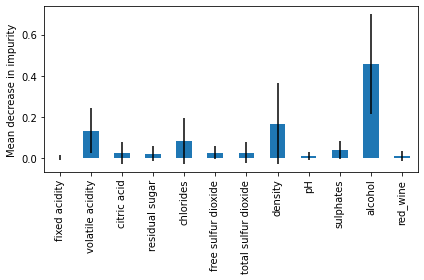

In [49]:
# Get feature importance, which  are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[  0,   5,  35,   0,   0],
       [  0,   8, 178,  13,   0],
       [  0,   7, 434, 124,   0],
       [  0,   0, 177, 263,   0],
       [  0,   0,  31,  29,   0]])